# Recurrent Neural Network 

## Classifying Names with a Character-Level RNN 

- Reference: [RNN PyTorch Tutorial](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html)

You can download the data from [this link](https://download.pytorch.org/tutorial/data.zip).

In [1]:
import DataPreprocess

The number of names in Czech is 519
The number of names in German is 724
The number of names in Arabic is 2000
The number of names in Japanese is 991
The number of names in Chinese is 268
The number of names in Vietnamese is 73
The number of names in Russian is 9408
The number of names in French is 277
The number of names in Irish is 232
The number of names in English is 3668
The number of names in Spanish is 298
The number of names in Greek is 203
The number of names in Italian is 709
The number of names in Portuguese is 74
The number of names in Scottish is 100
The number of names in Dutch is 297
The number of names in Korean is 94
The number of names in Polish is 139
Total number of data is 20074


In [1]:
import torch
from torch import nn

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## Bring Dataset

- The dataset contains names of people from 18 different nations.
- We want to train a neural network that classifies a name to its corresponding nation.

In [3]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

['data/names/Czech.txt', 'data/names/German.txt', 'data/names/Arabic.txt', 'data/names/Japanese.txt', 'data/names/Chinese.txt', 'data/names/Vietnamese.txt', 'data/names/Russian.txt', 'data/names/French.txt', 'data/names/Irish.txt', 'data/names/English.txt', 'data/names/Spanish.txt', 'data/names/Greek.txt', 'data/names/Italian.txt', 'data/names/Portuguese.txt', 'data/names/Scottish.txt', 'data/names/Dutch.txt', 'data/names/Korean.txt', 'data/names/Polish.txt']


## Data Preprocessing

In [4]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

In [5]:
all_letters

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'"

In [6]:
n_letters

57

In [7]:
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [8]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [9]:
# Target Classes of the data

all_categories

['Czech',
 'German',
 'Arabic',
 'Japanese',
 'Chinese',
 'Vietnamese',
 'Russian',
 'French',
 'Irish',
 'English',
 'Spanish',
 'Greek',
 'Italian',
 'Portuguese',
 'Scottish',
 'Dutch',
 'Korean',
 'Polish']

In [10]:
# Examples

print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [12]:
# Finding the total number of data

num_data = 0

for nation in all_categories:
    n = len(category_lines[nation])
    print('The number of names in ' + nation + ' is', n)
    num_data += n

print('='*40)
print('Total number of data is', num_data)

The number of names in Czech is 519
The number of names in German is 724
The number of names in Arabic is 2000
The number of names in Japanese is 991
The number of names in Chinese is 268
The number of names in Vietnamese is 73
The number of names in Russian is 9408
The number of names in French is 277
The number of names in Irish is 232
The number of names in English is 3668
The number of names in Spanish is 298
The number of names in Greek is 203
The number of names in Italian is 709
The number of names in Portuguese is 74
The number of names in Scottish is 100
The number of names in Dutch is 297
The number of names in Korean is 94
The number of names in Polish is 139
Total number of data is 20074


In [13]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [14]:
print(letterToTensor('J'))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])


In [15]:
print(lineToTensor('Jones'))
print(lineToTensor('Jones').size())

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

## Define the Recurrent Neural Network

We need to specify three layers;
- Input size: the dimension of data.
- Hidden size: the dimension of hidden vector.
- Output size: the number of classes.

In [80]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, h):
        combined = torch.cat((x, h), dim=1)
        h = self.i2h(combined)
        o = self.i2o(combined)
        o = self.softmax(o)
        return o, h

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [81]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [82]:
print('Input dimension of RNN:', n_letters)
print('Hidden dimension of RNN:', n_hidden)
print('Output dimension of RNN:', n_categories, '= number of classes.')

Input dimension of RNN: 57
Hidden dimension of RNN: 128
Output dimension of RNN: 18 = number of classes.


### Examples

In [83]:
x = letterToTensor('A')
h = torch.zeros(1, n_hidden)

output, next_hidden = rnn(x, h)

In [84]:
print(letterToTensor('A'))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])


In [85]:
x = lineToTensor('Albert')
h = torch.zeros(1, n_hidden)

o, next_h = rnn(x[0], h)
print(o)

tensor([[-2.9646, -2.9769, -2.8701, -2.7996, -2.9200, -2.9440, -2.8530, -2.9500,
         -2.9436, -2.8270, -2.7969, -2.9698, -2.8781, -2.9395, -2.9501, -2.8339,
         -2.8238, -2.8210]], grad_fn=<LogSoftmaxBackward>)


### Define Some Functions for Training the Network

- ```categoryFromOutput```: Converts an output vector (log softmax output) into the class label which corresponds to the index of the largest index of the output vector.

- ```randomChoice```: Given a list, choose a random element in the list.

- ```randomTrainingExample```: Randomly sample a data.


In [86]:
# Converts an output vector (log softmax output) into the class label 
# which corresponds to the index of the largest index of the output vector.

def categoryFromOutput(output):
    
    # Choose the largest value (top_n) and its corresponding index (top_i) from the output vector.
    top_n, top_i = output.topk(1)
    
    # Convert the index of a tensor to the index of classes.
    category_i = top_i[0].item()
    
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Spanish', 10)


In [87]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    
    # Randomly chosen nation
    category = randomChoice(all_categories)
    
    # Randomly chosen name
    line = randomChoice(category_lines[category])
    
    # Convert the nation into a tensor. (Integer, 0~17)
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    
    # Convert the name into its corresponding one-hot tensor
    line_tensor = lineToTensor(line)
    
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Scottish / line = Watson
category = Korean / line = Ngai
category = Greek / line = Bouloukos
category = Irish / line = Naoimhin
category = Chinese / line = Zong
category = Czech / line = Netsch
category = French / line = Bordelon
category = Polish / line = Kijek
category = Italian / line = Amello
category = Spanish / line = Valdez


In [88]:
randomTrainingExample()

('Spanish',
 'Espina',
 tensor([10]),
 tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

## Define Loss, Optimizer, and Training

- ```NLLLoss```: Negative Log Likelihood Loss. ***NEEDS ```LogSoftmax()``` layer*** in the model.

- ```train```: Update the network ***per a data pair***. 

In [89]:
import torch.optim as optim

In [90]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(rnn.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                     lr_lambda=lambda epoch: 0.95 ** epoch,
                                     last_epoch=-1,
                                     verbose=True)

Adjusting learning rate of group 0 to 1.0000e-02.


In [91]:
# One Iteration per a data point.

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    optimizer.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()

    return output, loss.item()

### Main Code of Training the Network

In [92]:
num_data

20074

In [93]:
import time
import math

EPOCHS = 30
n_iters = num_data * EPOCHS
print_every = 5000
plot_every = 1000


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
    # Adjust Learning rate per each epoch.
    if iter % num_data == 0:
        print('EPOCH %d Completed.'%(iter//num_data))
        scheduler.step()

5000 0% (0m 6s) 273705.3750 Jaeger / Italian ✗ (German)
10000 1% (0m 13s) 925202304.0000 Tassioglou / French ✗ (Greek)
15000 2% (0m 19s) 193167.7812 Kassis / English ✗ (Arabic)
20000 3% (0m 26s) 0.0000 Poroskov / Russian ✓
EPOCH 1 Completed.
Adjusting learning rate of group 0 to 9.5000e-03.
25000 4% (0m 32s) 20311998.0000 Amagawa / Czech ✗ (Japanese)
30000 4% (0m 40s) 12629456.0000 Masudu / Greek ✗ (Japanese)
35000 5% (0m 47s) 9116752.0000 Macias / Irish ✗ (Spanish)
40000 6% (0m 54s) 10.7718 Ho / Korean ✗ (Vietnamese)
EPOCH 2 Completed.
Adjusting learning rate of group 0 to 9.0250e-03.
45000 7% (1m 1s) 81325824.0000 Basurto / German ✗ (Portuguese)
50000 8% (1m 8s) 16.3409 Mo / Chinese ✗ (Korean)


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()

/var/folders/j_/45z7qrp57fq6gc7pn9bn7n_40000gn/T/ipykernel_17749/3585656379.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/var/folders/j_/45z7qrp57fq6gc7pn9bn7n_40000gn/T/ipykernel_17749/3585656379.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


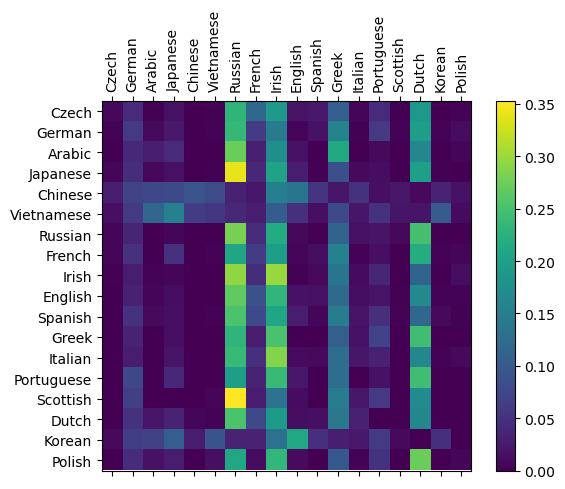

In [78]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [79]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(0.00) Irish
(-13588711.00) Korean
(-13875094.00) Greek

> Jackson
(0.00) Irish
(-16829726.00) Portuguese
(-19792850.00) Scottish

> Satoshi
(0.00) Japanese
(-148619.44) Polish
(-1975589.12) Italian
